In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from encoders_decoders import *
from losses import *

In [2]:
N = 20
mu0 = torch.arange(0,10,10/N)[None,:]
sigma0 = torch.ones(N)[None,:]
q0 = 1/N*torch.ones(N)[None,:]

#Define data distribution
x_data = torch.distributions.exponential.Exponential(0.5).sample((500,))[:,None]
x_sorted,indices = x_data.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item() 

encoder = CategoricalEncoder(mu0,sigma0,q0)
decoder = GaussianDecoder(mu0,sigma0,q0)

#Define optimizer and parameters to iterate on
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.SGD(params,lr=0.001,momentum=0.9)
loss = distortion(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)

C:\Users\auror\Thesis\encoders_decoders.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))
C:\Users\auror\Thesis\losses.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = -((F.softmax(p_j_x))*logq_x_j).sum(dim=1).mean()
C:\Users\auror\Thesis\losses.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()
C:\Users\auror\Thesis\losses.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()


In [3]:
loss_tot = []
mse_val = []

for i in range(1,2000):
    running_loss_tot=0
    running_mse=0
   
    loss = distortion(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)
    mse=MSE(x_data, encoder, decoder)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    running_loss_tot = loss.item()
    running_mse = mse.item()

    
    loss_tot.append(running_loss_tot)
    mse_val.append(running_mse)
   


C:\Users\auror\Thesis\losses.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mse = ((F.softmax(p_j_x))*(x_data**2 + decoder.mu.transpose(0,1)**2 -2*x_data*decoder.mu.transpose(0,1) + decoder.sigma.transpose(0,1)**2)).sum(dim=1).mean()


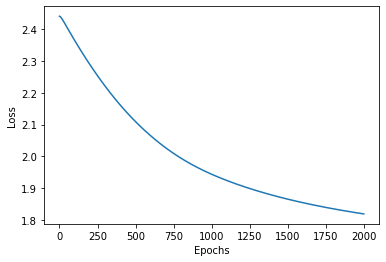

In [4]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_tot) 

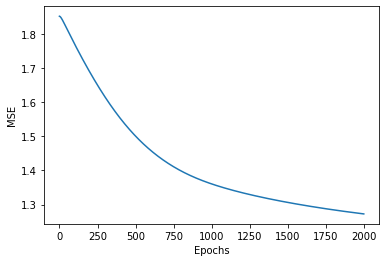

In [5]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(mse_val)

# Encoding

<ipython-input-6-9548d405fd28>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,6]))


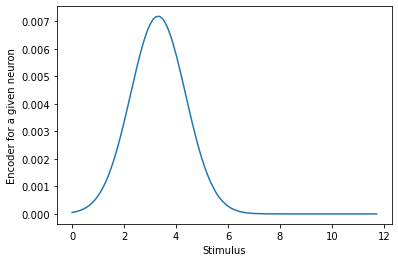

In [6]:
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoder for a given neuron")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,6]))   

<ipython-input-7-d6e3f776e5d9>:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:]))


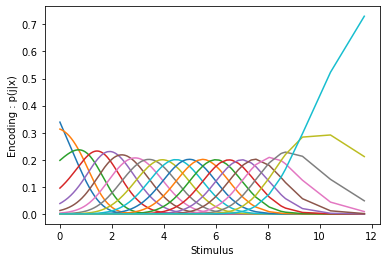

In [7]:
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding : p(j|x)")
    plt.plot(x_sorted,F.softmax(encoder(x_sorted)[:,:]))   
    

# Decoding

In [8]:
res = GaussianDecoder(mu0,sigma0,q0)
mu_dec, sigma_dec = res(x_sorted)

C:\Users\auror\Thesis\encoders_decoders.py:93: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.q  = torch.nn.Parameter(F.softmax(q0))


In [9]:
list(mu_dec)


[tensor([0.5329], grad_fn=<UnbindBackward>),
 tensor([0.6234], grad_fn=<UnbindBackward>),
 tensor([0.8415], grad_fn=<UnbindBackward>),
 tensor([1.2012], grad_fn=<UnbindBackward>),
 tensor([1.5911], grad_fn=<UnbindBackward>),
 tensor([2.0320], grad_fn=<UnbindBackward>),
 tensor([2.5492], grad_fn=<UnbindBackward>),
 tensor([3.1245], grad_fn=<UnbindBackward>),
 tensor([3.7171], grad_fn=<UnbindBackward>),
 tensor([4.2949], grad_fn=<UnbindBackward>),
 tensor([4.8455], grad_fn=<UnbindBackward>),
 tensor([5.3760], grad_fn=<UnbindBackward>),
 tensor([5.8978], grad_fn=<UnbindBackward>),
 tensor([6.4147], grad_fn=<UnbindBackward>),
 tensor([6.9281], grad_fn=<UnbindBackward>),
 tensor([7.4418], grad_fn=<UnbindBackward>),
 tensor([7.9582], grad_fn=<UnbindBackward>),
 tensor([8.4775], grad_fn=<UnbindBackward>),
 tensor([9.0038], grad_fn=<UnbindBackward>),
 tensor([9.5447], grad_fn=<UnbindBackward>)]

In [10]:
list(sigma_dec)

[tensor([0.4213], grad_fn=<UnbindBackward>),
 tensor([0.4659], grad_fn=<UnbindBackward>),
 tensor([0.5834], grad_fn=<UnbindBackward>),
 tensor([0.7370], grad_fn=<UnbindBackward>),
 tensor([0.8353], grad_fn=<UnbindBackward>),
 tensor([0.9106], grad_fn=<UnbindBackward>),
 tensor([0.9961], grad_fn=<UnbindBackward>),
 tensor([1.0765], grad_fn=<UnbindBackward>),
 tensor([1.1129], grad_fn=<UnbindBackward>),
 tensor([1.0978], grad_fn=<UnbindBackward>),
 tensor([1.0621], grad_fn=<UnbindBackward>),
 tensor([1.0388], grad_fn=<UnbindBackward>),
 tensor([1.0299], grad_fn=<UnbindBackward>),
 tensor([1.0235], grad_fn=<UnbindBackward>),
 tensor([1.0208], grad_fn=<UnbindBackward>),
 tensor([1.0255], grad_fn=<UnbindBackward>),
 tensor([1.0319], grad_fn=<UnbindBackward>),
 tensor([1.0397], grad_fn=<UnbindBackward>),
 tensor([1.0609], grad_fn=<UnbindBackward>),
 tensor([1.0936], grad_fn=<UnbindBackward>)]

In [11]:
gaussian = torch.distributions.normal.Normal(mu_dec, sigma_dec)

In [12]:
a = (gaussian.log_prob(x_sorted.transpose(0,1))).transpose(0,1)

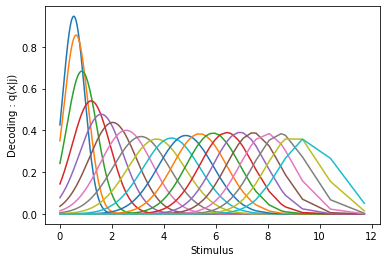

In [13]:
with torch.no_grad():
    plt.plot(x_sorted, torch.exp(a[:,:]))
    plt.xlabel("Stimulus")
    plt.ylabel("Decoding : q(x|j)")
    
    
    

In [22]:
q_sample = torch.squeeze(torch.distributions.categorical.Categorical((F.softmax(decoder.q))).sample((500,)))

<ipython-input-22-023266c519cc>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  q_sample = torch.squeeze(torch.distributions.categorical.Categorical((F.softmax(decoder.q))).sample((500,)))


In [23]:
muext,sigmaext =decoder(F.one_hot(q_sample).to(dtype=torch.float32))

In [24]:
muext.shape

torch.Size([20, 1])

In [25]:
x_sample = torch.distributions.normal.Normal(muext,sigmaext).sample() 

In [26]:
x_sample.shape

torch.Size([20, 1])

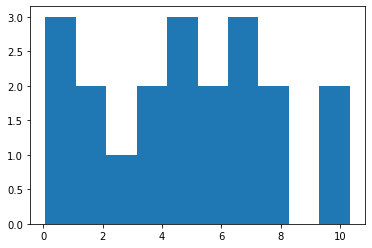

In [27]:
with torch.no_grad():
    
    plt.hist(x_sample.numpy())

# MSE

Computing the loss as Mean Squared Erros + KL Divergence

In [15]:
optimizer = torch.optim.SGD(params,lr=0.001,momentum=0.9)
loss = MSE(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)

C:\Users\auror\Thesis\losses.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mse = ((F.softmax(p_j_x))*(x_data**2 + decoder.mu.transpose(0,1)**2 -2*x_data*decoder.mu.transpose(0,1) + decoder.sigma.transpose(0,1)**2)).sum(dim=1).mean()
C:\Users\auror\Thesis\losses.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()
C:\Users\auror\Thesis\losses.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  dkl = ((F.softmax(p_j_x))*(F.log_softmax(p_j_x) - F.log_softmax(decoder.q))).sum(dim=1).mean()


In [16]:
loss_tot = []

for i in range(1,2000):
    running_loss_tot=0
   
    
    
    loss = MSE(x_data, encoder, decoder) + Dkl(x_data, encoder, decoder)
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    running_loss_tot = loss.item()
    loss_tot.append(running_loss_tot)

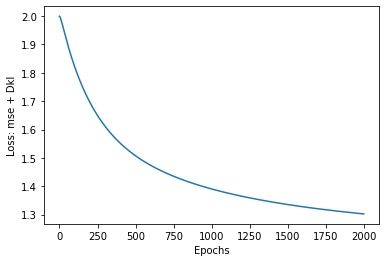

In [19]:
plt.xlabel("Epochs")
plt.ylabel("Loss: mse + Dkl")
plt.plot(loss_tot) 
